In [ ]:
import numpy as np  
import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam


from typing import Any , Literal
import warnings
warnings.filterwarnings('ignore' ,"" , DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set Seaborn style
sns.set_style("darkgrid")

In [ ]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.soo.nonconvex.pso import PSO

from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter


from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util import plotting



from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

from pymoo.operators.selection.tournament import TournamentSelection 

In [ ]:
# Make Static List

from _collections_abc import dict_items, dict_keys, dict_values
from collections.abc import Iterator


class static_list(list):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.x = list()
        pass
    def __str__(self) -> str:
        return f"{self.x}"
    def __repr__(self) -> str:
        return f"static_list({self.x})"
    def __iter__(self) -> Iterator:
        return self.x.__iter__()
    
    def __len__(self) -> int:
        return len(self.x)
    
    def append(self, value : Any , sorted : bool = False):
        if len(self.x) == self.volume:
            self.x.append(  value )
            self.x.pop(0)
            self.x.sort(reverse = True) if sorted else None
        else :
            self.x.append(  value )
            self.x.sort(reverse = True) if sorted else None
        self.__repr__()
        pass
      
    def to_list(self) -> list:
        return self.x
    def to_numpy(self) -> np.ndarray :
        return np.array(self.x)


class static_dict(dict):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.solution = dict()
        pass
    def __str__(self) -> str:
        return f"{self.solution}"
    def __repr__(self) -> str:
        return f"static_dict({self.solution})"
    def keys(self) -> dict_keys:
        return list(self.solution.keys())
    def values(self) -> dict_values:
        return list(self.solution.values())
    def items(self) -> dict_items:
        return list(self.solution.items())
    def __iter__(self) -> Iterator:
        return self.solution.__iter__()
    
    def add(self, value : tuple):
        if len(self.solution) == self.volume:
            self.solution[value[0]] =  value[1]
            self.solution.pop( list(self.solution.keys()) [0])
        else :
            self.solution[value[0]] =  value[1]

        self.__repr__()
        pass

In [ ]:
def binary_tournament(pop, P, **kwargs):
    # The P input defines the tournaments and competitors
    n_tournaments, n_competitors = P.shape

    if n_competitors != 2:
        raise Exception("Only pressure=2 allowed for binary tournament!")

    # the result this function returns

    S = np.full(n_tournaments, -1, dtype=np.int)

    # now do all the tournaments
    for i in range(n_tournaments):
        a, b = P[i]

        # if the first individual is better, choose it
        if pop[a].F < pop[b].F:
            S[i] = a

        # otherwise take the other individual
        else:
            S[i] = b

    return S

def tradition(name , population, cross_over_rate, mutation_over_rate ):
    ref_point = 1 if name == 'ackley' else 3
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", ref_point, n_partitions=population.shape[0])
    # create the algorithm object
    algorithm = PSO(pop_size=None,
                    ref_dirs=ref_dirs,
                    sampling = population,
                    selection=TournamentSelection(func_comp=binary_tournament),
                     crossover=SBX( eta= 1 , prob= cross_over_rate ),
                     mutation=PM(eta=1, prob= mutation_over_rate ),)
    # execute the optimization
    problem = get_problem("ackley", n_var=population.shape[1], a=20, b=1/5, c=2 * np.pi) if name == "ackley" else get_problem(name)

    res = minimize(problem,
                algorithm,
                seed=1,
                termination=('n_gen', 1))
    return res.solution

In [ ]:
class learning_aided_evolution:
    def __init__(self,
                problem: Literal["dtlz1", "dtlz2", "dtlz3", "dtlz4",
                                "dtlz5", "dtlz6", "dtlz7", "ackley"] = "dtlz1",
                arch_size: int = 100,
                cross_over_rate: float = .5,
                mutation_rate: float = .9,
                n_obj: int = 3) -> None:
        self.problem = problem
        self.arch_size = arch_size
        self.cross_over_rate = cross_over_rate
        self.mutation_rate = mutation_rate
        self.n_obj = n_obj

        if problem in [ "dtlz2", "dtlz3", "dtlz4", "dtlz5", "dtlz6", "dtlz7", 'ackley' ]:
            self.n_var = 10
        elif problem in ['dtlz1']:
            self.n_var = 7
        else:
            raise Exception ("bad problem name")
    
    def cross_over(self, X_A, X_B, mutation_rate):
        if np.random.rand() <= mutation_rate:
            return X_A
        else:
            return X_B
        
    def mutation(self, X_A, X_B,X_C, ):
        """
        XA + cross_over_rate * (XB - Xc)
        """
        return X_A + self.nutaion_rate * (X_B - X_C)

    def tournament_selection(self, population, k, ):  # population is a list of individuals
        population = population.tolist() if isinstance(population, np.ndarray) else population
        # generate the random array
        # use the choice method of the Generator class
        rng = np.random.default_rng()
        A_sampled = rng.choice(population, k)
        return A_sampled


    def run(self , Xg, newX ):
        newX = list()
        for i in range(1, len(Xg) ):
            LC = self.cross_over(Xg[1-i] , Xg[i ], self.cross_over_rate)
            newX.append(LC)

        for i in range(2, len(Xg) ):
            LM = self.mutation( Xg[i - 2], Xg[i - 1], Xg[i], self.mutation_rate)
            newX.append(LM)
        
        selection = self.tournament_selection( newX, Xg.shape[0],self.n_obj, 100 )
        return selection[-1] if self.problem == 'ackley' else selection




In [ ]:
def tradition(name , population, cross_over_rate, mutation_over_rate ):
    ref_point = 1 if name == 'ackley' else 3
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", ref_point, n_partitions=population.shape[0])
    # create the algorithm object
    algorithm = PSO(pop_size=None,
                    ref_dirs=ref_dirs,
                    sampling = population,
                    selection=TournamentSelection(func_comp=binary_tournament),
                     crossover=SBX( eta= 1 , prob= cross_over_rate ),
                     mutation=PM(eta=1, prob= mutation_over_rate ),)
    # execute the optimization
    problem = get_problem("ackley", n_var=population.shape[1], a=20, b=1/5, c=2 * np.pi) if name == "ackley" else get_problem(name)

    res = minimize(problem,
                algorithm,
                seed=1,
                termination=('n_gen', 1))
    return res.X

In [ ]:
# initialize_ANN
def initialize_ANN(n_var, lr = 0.1):
# Create the modelweights_randomly
    # print(n_var, n_obj)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=n_var,  name = "Input"),
        tf.keras.layers.Dense(n_var * 3, activation='relu',  name = "hidden"),
        tf.keras.layers.Dense(n_var , activation = "softmax", name = "Output")
    ])

    model.compile(optimizer=Adam(.1), loss='mse')
    return model

In [ ]:
# train_ANN
def train_ANN(model, X_train, y_train) -> np.ndarray:
    hist = model.fit(X_train, y_train, epochs=1, verbose=False)
    ypred = model.predict(X_train, verbose=False)
    return ypred[0] , hist.history['loss']


In [ ]:
def initialize_population(population_size, num_variables, num_ojective):
    problem = Problem(n_var = num_variables, n_obj = num_ojective ,  xl=0, xu=1)
    sampling = FloatRandomSampling()
    X = sampling(problem, population_size).get("X")
    return X


Xg_ = initialize_population(100, 10, 3)

In [ ]:
def MSE(arch_size, Lx, X):
    # Lx = np.argmax(Lx, axis=1)
    summ = np.sum(np.abs(Lx - X) ** 2)
    return (1/arch_size) * summ

In [ ]:
def ackley( solution : np.ndarray, *args)-> float :
    """
    Ackley function implementation.
    
    Parameters:
    solution (numpy.ndarray): Input vector (solution).
    
    Returns:
    float: Value of the Ackley function at the given input vector.
    """
    # print(solution)
    solution = np.array(solution) if not isinstance(solution, np.ndarray) else solution
    a = 20
    b = 0.2
    c = 2 * np.pi
    # print("solution\n",solution)    
    term1 = -a * np.exp(-b * np.sqrt((1 / len(solution)) * np.sum(solution**2)))
    term2 = -np.exp((1 / len(solution)) * np.sum(np.cos(c * solution)))
    
    value = term1 + term2 + a + np.exp(1)
    
    return value

def dtlz1( solution: np.ndarray, n_obj: int) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = 100 * (k + sum((solution[i] - 0.5)**2 - np.cos(20 * np.pi * (solution[i] - 0.5)) for i in range(n_var - k)))
    # initialize the objective vector
    f = [0.5 * (1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= solution[j]
        if i > 0:
            f[i] *= 1 - solution[n_obj - i - 1]
    # return the objective vector
    return np.array(f)

def dtlz2( solution: np.ndarray, n_obj: int) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = sum((solution[i] - 0.5)**2 for i in range(n_var - k))
    # initialize the objective vector
    f = [(1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= np.cos(solution[j] * np.pi / 2)
        if i > 0:
            f[i] *= np.sin(solution[n_obj - i - 1] * np.pi / 2)
    # return the objective vector
    return np.array(f)

def dtlz3( solution: np.ndarray, n_obj: int) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = 100 * (k + sum((solution[i] - 0.5)**2 - np.cos(20 * np.pi * (solution[i] - 0.5)) for i in range(n_var - k)))
    # initialize the objective vector
    f = [(1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= np.cos(solution[j] * np.pi / 2)
        if i > 0:
            f[i] *= np.sin(solution[n_obj - i - 1] * np.pi / 2)
    # return the objective vector
    return np.array(f)

def dtlz4( solution: np.ndarray, n_obj: int, alpha=100) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = sum((solution[i] - 0.5)**2 for i in range(n_var - k))
    # initialize the objective vector
    f = [(1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= np.cos((solution[j]**alpha) * np.pi / 2)
        if i > 0:
            f[i] *= np.sin((solution[n_obj - i - 1]**alpha) * np.pi / 2)
    # return the objective vector
    return np.array(f)

def dtlz5( solution: np.ndarray, n_obj: int) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = sum((solution[i] - 0.5)**2 for i in range(n_var - k))
    # calculate theta_1
    theta_1 = solution[0] * np.pi / 2
    # calculate theta_i for i > 1
    theta = [theta_1] + [np.pi / (4 * (1 + g)) * (1 + 2 * g * solution[i]) for i in range(1, n_obj - 1)]
    # initialize the objective vector
    f = [(1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= np.cos(theta[j])
        if i > 0:
            f[i] *= np.sin(theta[n_obj - i - 1])
    # return the objective vector
    return np.array(f)

def dtlz6( solution: np.ndarray, n_obj: int) -> np.ndarray:
    # get the number of decision variables
    n_var = len(solution)
    # get the number of variables in x_M
    k = n_var - n_obj + 1
    # calculate g(x_M)
    g = sum(solution[i]**0.1 for i in range(n_var - k))
    # calculate theta_1
    theta_1 = solution[0] * np.pi / 2
    # calculate theta_i for i > 1
    theta = [theta_1] + [np.pi / (4 * (1 + g)) * (1 + 2 * g * solution[i]) for i in range(1, n_obj - 1)]
    # initialize the objective vector
    f = [(1 + g)] * n_obj
    # calculate the objective values
    for i in range(n_obj):
        for j in range(n_obj - i - 1):
            f[i] *= np.cos(theta[j])
        if i > 0:
            f[i] *= np.sin(theta[n_obj - i - 1])
    # return the objective vector
    return np.array(f)

def dtlz7( solution : np.ndarray , n_vars : int) -> np.ndarray:
    g = 1 + (9 / len(solution)) * sum(solution[n_vars - 1:])
    f1 = solution[0]
    h = n_vars - sum([(solution / (1 + g)) * (1 + np.sin(3 * np.pi * solution)) for solution in solution[:n_vars - 1]])
    f2 = (1 + g) * h
    return np.array([f2 + f1])


In [ ]:
def fitness(name : str, 
            indivisual: np.ndarray , 
            n_objective: int) -> float| np.ndarray:
    match name:
        case "dtlz1":
            return dtlz1( indivisual , n_objective)
        case "dtlz2":
            return dtlz2( indivisual , n_objective)
        case "dtlz3":
            return dtlz3( indivisual , n_objective)
        case "dtlz4":
            return dtlz4( indivisual , n_objective)
        case "dtlz5":
            return dtlz5( indivisual , n_objective)
        case "dtlz6":
            return dtlz6( indivisual , n_objective)
        case "dtlz7":
            return dtlz7( indivisual, n_objective)
        case "ackley":
            return ackley( indivisual , n_objective)
        case _ :
            raise ValueError("bad arg")
        
        
def time_fitness(function, *args, **kwargs):
  start_time = time.time()
  LX = function(*args, **kwargs)
  end_time = time.time()
  time_delay = (end_time - start_time) / 1000 
  return time_delay , LX

In [ ]:
def is_better(problem : str,
                individual_1 : np.ndarray,
                individual_2 : np.ndarray,
                n_objective : int) -> tuple[bool, np.ndarray]:
    
    fitness_individual_1 = fitness( problem, 
                                    individual_1,
                                    n_objective)
    
    fitness_individual_2 = fitness( problem, 
                                    individual_2,
                                    n_objective)

    if np.median(fitness_individual_1) < np.median(fitness_individual_2):
        
        return True , individual_1
    else:
        return False , individual_2

In [ ]:
def selection(problem : str,
              Xg :np.ndarray, 
              newX : np.ndarray,
              n_obj : int) -> np.ndarray:
               
    selected = list()
    if  problem == 'ackley':
        better = is_better(problem, Xg, newX , n_obj)
        return better[1]
    else: 
        for  i , j in zip (Xg, newX):
            # print(i, j)
            better = is_better(problem, i, j , n_obj)
            if better[0]:
                selected.append( i )
            else :
                selected.append( j )

        return np.array(selected)

In [145]:
def main(
    Problem : object,
    archive_size : int,
    lp : float,
    n_generations : int,
    first_gen_size : int,
    n_obj : int,
    cross_over_rate : float,
    mutation_rate : float,
    plot : bool
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if Problem in [ "dtlz2", "dtlz3", "dtlz4", "dtlz5", "dtlz6", "dtlz7", 'ackley' ]:
        n_var = 10
    elif Problem in ['dtlz1']:
        n_var = 7
        pass

    Xg  : np.ndarray = initialize_population(first_gen_size, n_var, n_obj )  # Initialize population and evaluate fitness
    ANN = initialize_ANN(n_var)  # Initialize ANN weights randomly
    archive = static_list(archive_size)  # Archive to store solution pairs
    all_solutions = static_list(archive_size)
    all_losses = static_list(archive_size)

    leo = learning_aided_evolution()
    # print(Xg[0])
    newX = Xg
    for gen in range(n_generations):
        r = np.random.rand()
        if gen > 1 and r < lp:
            newX = leo.run(Xg, newX)
        else :
            newX = tradition(Problem, Xg, cross_over_rate, mutation_rate )
            pass

        Xg_i = selection(Problem, Xg, newX, n_obj)
        # print(Xg_i[0])

        # SEP Collection
        for i in range(len(Xg_i) ):
            better = is_better(Problem, Xg_i[i ], Xg[i], n_obj)
            if better[0] :
                # print(better[0])
                archive.append( (Xg[i], 
                                 Xg_i[i]) )


        # print(archive)
        for x1, x2 in archive:
            # print(x1, x2)
            traind, loss = train_ANN(ANN, x1.reshape(1,-1), x2.reshape(1,-1))
            all_solutions.append(traind)
            all_losses.append( loss[0] )

        print(f"gen{gen+1}=", end= "")

    if plot:
        fig, ax = plt.subplots(1,3 , figsize=(15, 5))
        sns.scatterplot(Xg,            legend=False , ax=ax [0] )
        ax[0].set_xlabel('initialize population' , fontsize = 10)
        ax[0].grid(visible =True)

        sns.scatterplot(all_solutions.to_list(), legend=False , ax=ax [1] )
        ax[1].set_xlabel('solution population' , fontsize = 10)
        ax[1].grid(visible =True)

        sns.lineplot(all_losses,    legend=False , ax=ax [2] )
        ax[2].set_xlabel('MSE loss ' , fontsize = 10)

        ax[2].grid(visible =True)
        plt.show()
    
    return archive.to_numpy(), np.array(all_solutions), np.array(all_losses)
     

In [186]:
Archive , Solutions, loss = main(
    'dtlz1',
    archive_size=100,
    lp = .8,
    n_generations= 2,
    first_gen_size= 100,
    cross_over_rate= 1.,
    mutation_rate= 1.,
    n_obj= 7,
    plot = True,
)

gen1=gen2=

In [187]:
Solutions.shape 

(30, 7)

In [131]:
Archive.shape

(22, 2, 7)

In [171]:
%matplotlib qt

In [133]:
%matplotlib inline

In [188]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter3D(Solutions[:,0], 
                  Solutions[:,1],
                  Solutions[:,2],
                  c = Solutions[:,0], 
                   s = 40, 
                   marker = 'o', 
                   cmap = cmap , 
                   alpha = 1)
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


In [189]:
sns.scatterplot(Xg_[-1])
sns.scatterplot(Archive[-1][0])
sns.scatterplot(Solutions[-1], legend= "full")

plt.legend(['fist', 'Archive' ,'best'])
plt.show(block = False)

In [190]:


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter(Archive[:,:,0], Archive[:,:,1],
                 Archive[:,:,2],
                   s=40, c=Archive[:,:,0], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('f (1)')
ax.set_ylabel('f (2)')
ax.set_zlabel('f (3)')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


In [192]:
import scipy.stats as stats

# One-sided test (alternative hypothesis: sample1 > sample2)
statistic, pvalue = stats.wilcoxon(Archive[0,:,:][-1],
                                    Solutions[-1], 
                                    alternative='greater')
print("One-sided p-value:", pvalue)

# Two-sided test (alternative hypothesis: not equal medians)
statistic, pvalue = stats.wilcoxon(Archive[0,:,:][-1], 
                                   Solutions[-1], 
                                   alternative='two-sided')
print("Two-sided p-value:", pvalue)

One-sided p-value: 0.0078125
Two-sided p-value: 0.015625


In [183]:
import pandas as pd
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi

# # Create a pandas DataFrame with your data (replace with your actual data)
df = pd.DataFrame({
    'Group1': Solutions[:,0],
    'Group2': Solutions[:,1],
    'Group3': Solutions[:,2],
    'Group4' : Solutions[:,3],
    'Group5': Solutions[:,4],
    'Group6': Solutions[:,5],
    'Group7': Solutions[:,6],
   #  'Group8' : Solutions[:,7],
   #  'Group9': Solutions[:,8],
   #  'Group10': Solutions[:,9],
   #  'Group11': Solutions[:,12],

})

# Perform the Friedman test
friedman_result = friedmanchisquare(df['Group1'].to_numpy()
                                    ,df['Group2'].to_numpy()
                                    ,df['Group3'].to_numpy()
                                    ,df['Group3'].to_numpy()
                                    ,df['Group4'].to_numpy()
                                    ,df['Group5'].to_numpy()
                                    ,df['Group6'].to_numpy()
                                    # ,df['Group7'].to_numpy()
                                    # ,df['Group8'].to_numpy()
                                    # ,df['Group9'].to_numpy()
                                    # ,df['Group10'].to_numpy()
                                    )

# If significant, proceed with post-hoc analysis
if friedman_result.pvalue < 0.05:
    posthoc_result = posthoc_nemenyi(df, val_col = 'Group4', group_col= 'Group7')
    print(posthoc_result)
else:
    print("No significant differences detected.")


          0.009794  0.016251  0.017192  0.018389  0.020619  0.020799  \
0.009794       1.0       1.0       1.0       1.0       1.0       1.0   
0.016251       1.0       1.0       1.0       1.0       1.0       1.0   
0.017192       1.0       1.0       1.0       1.0       1.0       1.0   
0.018389       1.0       1.0       1.0       1.0       1.0       1.0   
0.020619       1.0       1.0       1.0       1.0       1.0       1.0   
0.020799       1.0       1.0       1.0       1.0       1.0       1.0   
0.021436       1.0       1.0       1.0       1.0       1.0       1.0   
0.021724       1.0       1.0       1.0       1.0       1.0       1.0   
0.022008       1.0       1.0       1.0       1.0       1.0       1.0   
0.031633       1.0       1.0       1.0       1.0       1.0       1.0   
0.033815       1.0       1.0       1.0       1.0       1.0       1.0   
0.037019       1.0       1.0       1.0       1.0       1.0       1.0   
0.040253       1.0       1.0       1.0       1.0       1.0      

In [184]:
np.where(posthoc_result <0)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
N_OBJ = 10
N_GENERATIONS = 10


gen1=gen2=

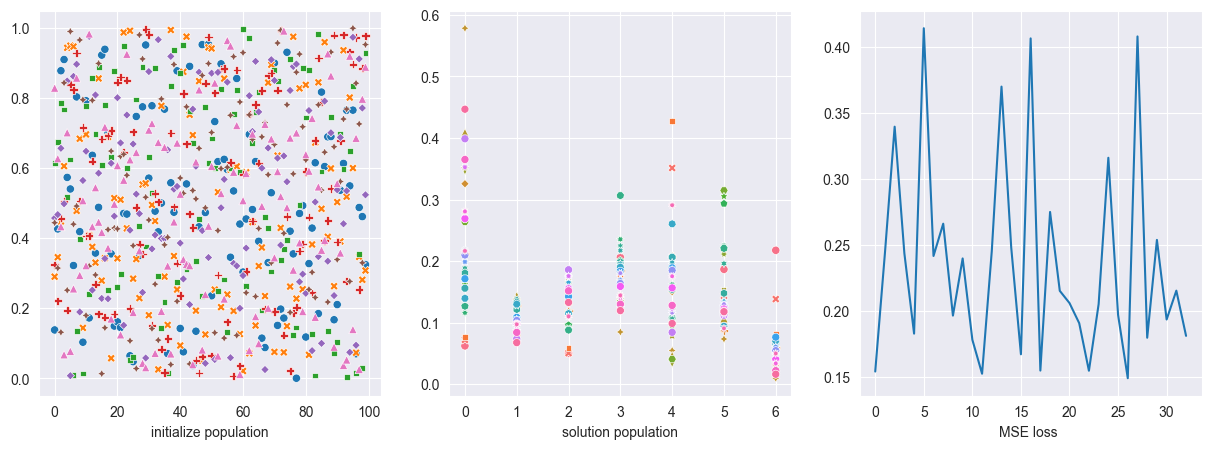

In [167]:
DTLZ1 = time_fitness(main , 
                       Problem= "dtlz1",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= 1,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz1_time_ , dtlz1_results = DTLZ1
dtlz1_res , dtlz1_arc , dtlz1_mse = dtlz1_results

gen1=gen2=

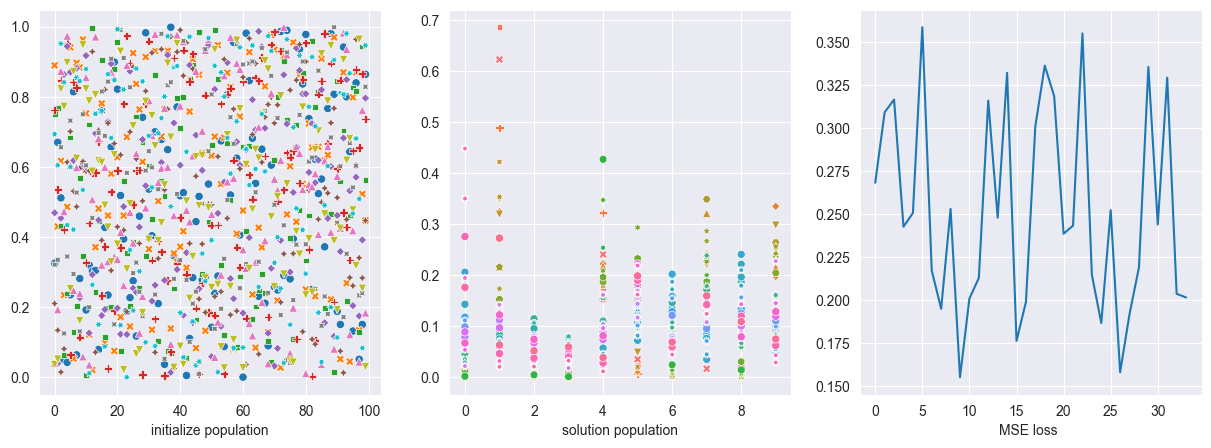

In [137]:
DTLZ2 = time_fitness(main , 
                       Problem= "dtlz2",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz2_time_ , dtlz2_results = DTLZ2
dtlz2_res , dtlz2_arc , dtlz2_mse = dtlz2_results

In [ ]:
DTLZ3 = time_fitness(main , 
                       Problem= "dtlz3",
            archive_size = 100,
            first_gen_size = 100,
            n_obj =N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz3_time_ , dtlz3_results = DTLZ3
dtlz3_res , dtlz3_arc , dtlz3_mse = dtlz3_results

gen1=gen2=

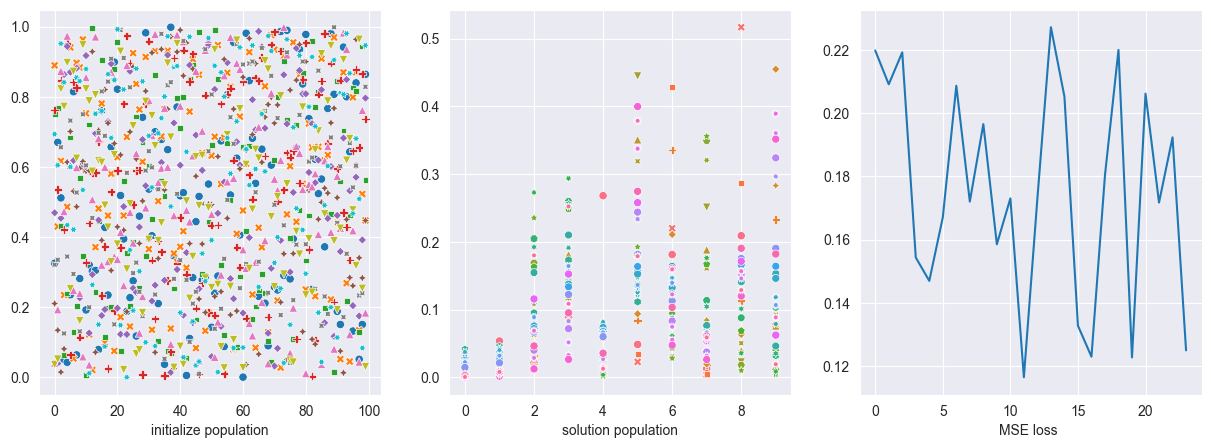

In [138]:
DTLZ4 = time_fitness(main , 
                       Problem= "dtlz4",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz4_time_ , dtlz4_results = DTLZ4
dtlz4_res , dtlz4_arc , dtlz3_mse = dtlz4_results

gen1=gen2=

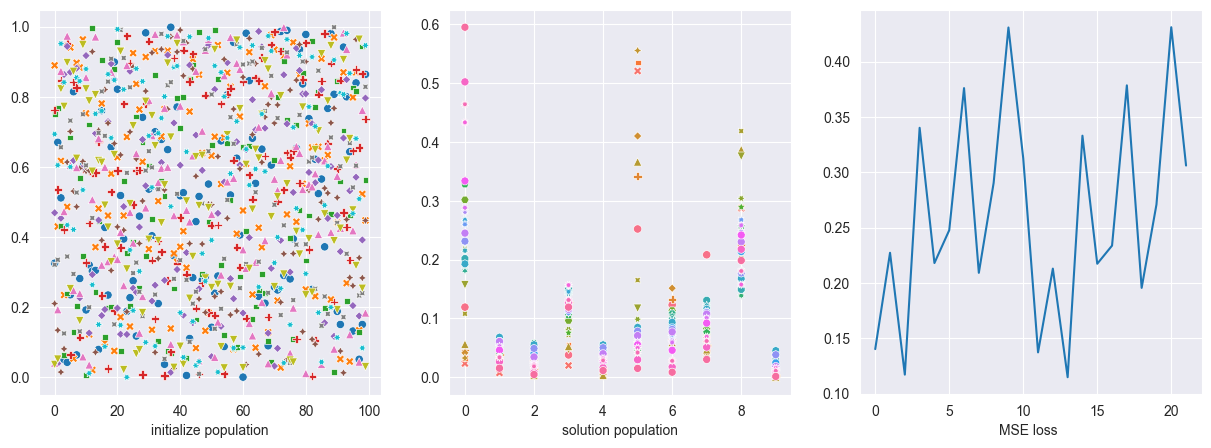

In [139]:
DTLZ5 = time_fitness(main , 
                       Problem= "dtlz5",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz5_time_ , dtlz5_results = DTLZ5
dtlz5_res , dtlz5_arc , dtlz5_mse = dtlz5_results

gen1=gen2=

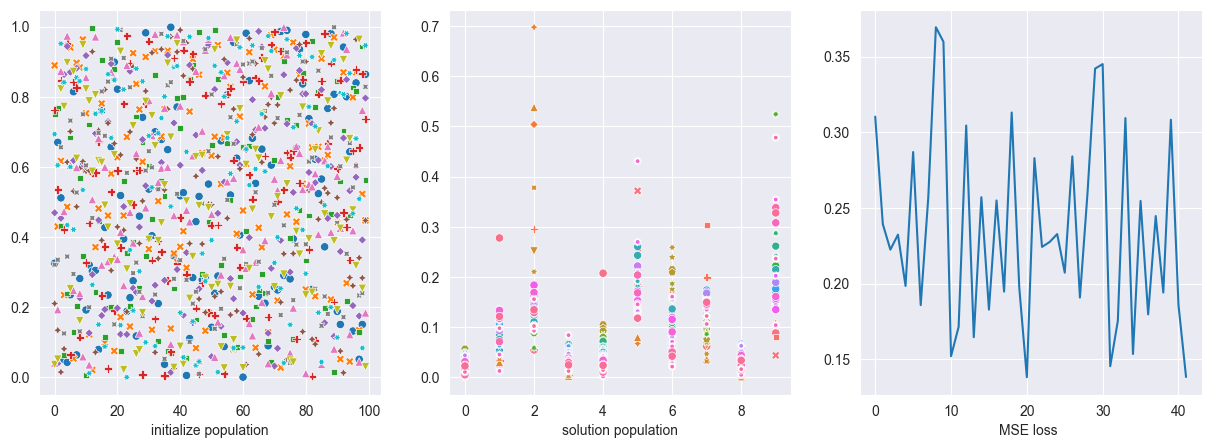

In [140]:
DTLZ6 = time_fitness(main , 
                       Problem= "dtlz6",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz6_time_ , dtlz6_results = DTLZ6
dtlz6_res , dtlz6_arc , dtlz6_mse = dtlz6_results

gen1=gen2=

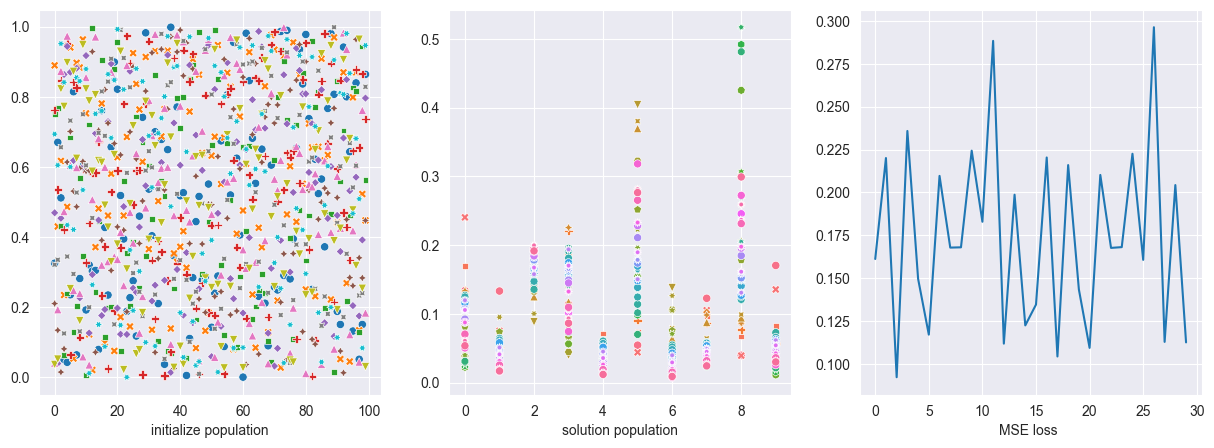

In [141]:
DTLZ7 = time_fitness(main , 
                       Problem= "dtlz7",
            archive_size = 100,
            first_gen_size = 100,
            n_obj = N_OBJ,
            lp= .5,
            n_generations= N_GENERATIONS,
            cross_over_rate = .5,
            mutation_rate = .9 ,
            plot= True)

dtlz7_time_ , dtlz7_results = DTLZ7
dtlz7_res , dtlz7_arc , dtlz7_mse = dtlz7_results